In [76]:
from qiskit import *
from qiskit.visualization import *
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.providers.ibmq import least_busy
import numpy as np
import math
from pylab import *
import matplotlib.pyplot as plt

In [3]:
IBMQ.load_accounts()

In [71]:
class DustCircuit(QuantumCircuit):
    def __init__(self, n_qbits, t, freq, alt_version=True):
        n_states = 2**n_qbits
        self.n_qbits = n_qbits
        self.alt_version = alt_version
        self.q = QuantumRegister(n_qbits)
        self.c = ClassicalRegister(n_qbits)
        self.dict_results = None
        self.statevector = None
        self.result = None        
        super().__init__(self.q,self.c)
        coefs = None
        if(alt_version): coefs = DustCircuit._generate_coefs2(n_qbits, t, freq)
        else: coefs = DustCircuit._generate_coefs1(n_states, t, freq)
        self.initialize(coefs, self.q)
    def simulate(self, nshots = 1000,backend=BasicAer.get_backend('qasm_simulator')):
        self.result = execute(self, backend, shots=nshots).result()        
        self.counts = self.result.get_counts(self)
        self.dict_results = {}
        if(self.alt_version):
            self.dict_results['0'] = self.counts['0'*self.n_qbits]            
            self.dict_results['1'] = nshots-self.dict_results['0']
        else:
            for key in list(self.counts.keys()):
                self.dict_results[int(key,2)] = self.counts[key]
        return self.result
    def simulate_statevector(self):
        self.result = execute(self, BasicAer.get_backend('statevector_simulator')).result()
        self.statevector = self.result.get_statevector(self)
        return self.result
    def execute(self, nshots = 1000, max_credits=3):
        large_enough_devices = IBMQ.backends(filters=lambda x: x.configuration().n_qubits < 10 and
                                                       not x.configuration().simulator)
        backend = least_busy(large_enough_devices)
        self.result = execute(self, backend, shots=nshots, max_credits=max_credits).result()
        self.counts = self.result.get_counts(self)
        self.dict_results = {}
        if(self.alt_version):
            self.dict_results['0'] = self.counts['0'*self.n_qbits]            
            self.dict_results['1'] = nshots-self.dict_results['0']
        else:
            for key in list(self.counts.keys()):
                self.dict_results[int(key,2)] = self.counts[key]
        return self.result
    def plot(self, how='histogram'):
        fig = None
        if (how == 'histogram'): fig = \
         plot_histogram(self.dict_results)
        elif (how == 'state_city'): fig = \
         plot_state_city(self.statevector)
        return fig    
    def exec_and_simulate(self, nshots = 1000, sim_backend = BasicAer.get_backend('qasm_simulator'), credits=3):
        self.simulate(nshots, backend=sim_backend)
        sim_results = self.dict_results        
        self.execute(nshots, max_credits=credits)
        self.dict_results = [sim_results, self.dict_results]        
    @staticmethod
    def _generate_coefs1(tam, t, freq):
        h, kB = 6.582119624 * 10**(-16), 8.6173324*10**(-5) #ctes    
        E = [h*freq*(i+1/2) for i in range(tam)]
        cNumerador = [math.exp(-E[i]/(kB*t)) for i in range(tam)]     
        sumDenom = math.sqrt(sum(cNumerador))
        c = [math.sqrt(cNumerador[i])/sumDenom for i in range(tam)]
        return c
    @staticmethod
    def _generate_coefs2(n, t, freq):
        tam = 2**n
        h, kB = 6.582119624 * 10**(-16), 8.6173324*10**(-5) #ctes    
        #E = [h*freq*(i+1/2) for i in range(tam)]
        E = []
        for i in list(map(lambda b: str(bin(b))[2:],range(tam))):
            mult = i.count('1')+n/2
            E.append(h*freq*mult)
        cNumerador = [math.exp(-E[i]/(kB*t)) for i in range(tam)]     
        sumDenom = math.sqrt(sum(cNumerador))
        c = [math.sqrt(cNumerador[i])/sumDenom for i in range(tam)]
        return c

In [46]:
t, freq = 15*10**9, 1.55*10**21 
DustCircuit._generate_coefs2(t, freq, 3)


1.5
0
2.5
1
2.5
10
3.5
11
2.5
100
3.5
101
3.5
110
4.5
111


[0.5702657828214867,
 0.38431421195809423,
 0.38431421195809423,
 0.25899750250175096,
 0.38431421195809423,
 0.25899750250175096,
 0.25899750250175096,
 0.17454391280606324]

In [66]:
t, freq = 15*10**9, 1.55*10**21 
c = DustCircuit(3, t, freq)
c.measure(c.q, c.c)
c.exec_and_simulate()


In [63]:
c.counts

{'101': 64,
 '110': 51,
 '111': 34,
 '000': 336,
 '100': 156,
 '001': 143,
 '011': 60,
 '010': 156}

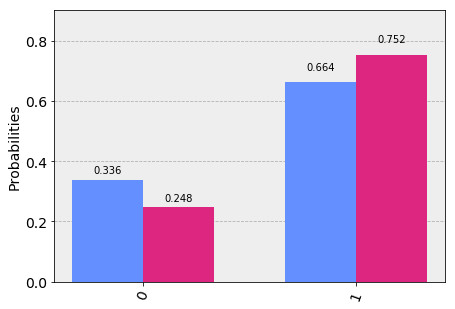

In [67]:
c.plot()

In [82]:
t, freq = 15*10**9, 1.55*10**21
max, shots = 5, 1000
x = range(1,max+1)
y0, y1 = [], []
for i in x:    
    c = DustCircuit(i, t, freq)
    c.measure(c.q, c.c)
    c.simulate(nshots=shots)
    y0.append(c.dict_results['0']/shots)
    y1.append(c.dict_results['1']/shots)

In [96]:
y0r , y1r = [], []
for i in x:    
    c = DustCircuit(i, t, freq)
    c.measure(c.q, c.c)
    c.execute(nshots=shots)
    y0r.append(c.dict_results['0']/shots)
    y1r.append(c.dict_results['1']/shots)

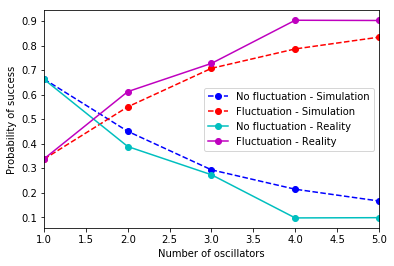

In [98]:
xlim(1,max)
xlabel("Number of oscillators")
ylabel("Probability of success")
p0 = plot(x, y0, 'bo--', label = "No fluctuation - Simulation")
p1 = plot(x, y1, 'ro--', label = "Fluctuation - Simulation")
p0r = plot(x, y0r, 'co-', label = "No fluctuation - Reality")
p1r = plot(x, y1r, 'mo-', label = "Fluctuation - Reality")

legend(loc='center right')
p0+p1+p0r+p1r


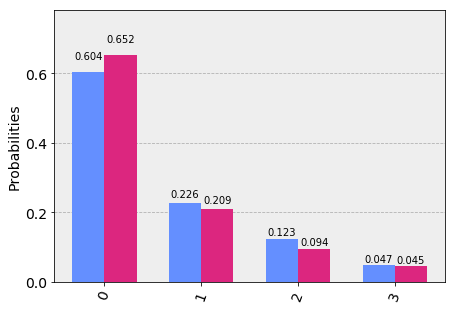

In [19]:
c.plot()

In [5]:

def matrizDensidad(tam, t, freq): #tam 4, estados 0 a 3
    h, kB = 6.582119624 * 10**(-16), 8.6173324*10**(-5) #ctes    
    E = [h*freq*(i+1/2) for i in range(tam)]
    #E = [-13.6, -9.37,-5.14,-0.9]
    
    cNumerador = [math.exp(-E[i]/(kB*t)) for i in range(tam)] 
    print(cNumerador)
    sumDenom = math.sqrt(sum(cNumerador))
    print(sumDenom)
    c = [math.sqrt(cNumerador[i])/sumDenom for i in range(tam)]
    
    
    #c[tam-1] = 1 - sum([math.sqrt(cNumerador[i])/sumDenom for i in range(tam)])
    
    print(c)
    m = np.matrix([[c[i]*c[j] for j in range(tam)] for i in range(tam)])
    return (m,c)


NameError: name 'coeficiente' is not defined

In [8]:
t, freq = 15*10**10, 1.55*10**21 
c = DustCircuit(4, t, freq)
c.measure(c.q, c.c)
#c.exec_and_show()
#large_enough_devices = IBMQ.backends(filters=lambda x: x.configuration().n_qubits < 10 and
#                                                       not x.configuration().simulator)
#backend = least_busy(large_enough_devices)
#job = execute(c, backend, shots=1000, max_credits=5)
#print (c)

In [ ]:
plot_histogram(job.result().get_counts())